* Course: DSC_550
*  Assignment: Week 10
*  Nels Findley

In [10]:
# Load libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import logging
import warnings

# Suppress all general Python warnings. There multiple warning that appear for compatability and 
# loading during training that can be hidden
warnings.filterwarnings('ignore')
logging.getLogger('torch').setLevel(logging.ERROR)

Using device: cpu

Displaying the first 5 training images and labels:


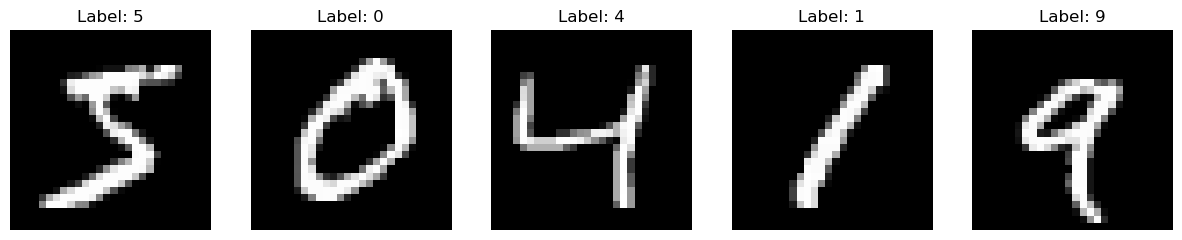


Starting training...
Epoch 1/3 complete. Loss: 0.0163
Epoch 2/3 complete. Loss: 0.0020
Epoch 3/3 complete. Loss: 0.0341

Test set: Average loss: 0.0296, Accuracy: 9911/10000 (99.11%)

Displaying Confusion Matrix...


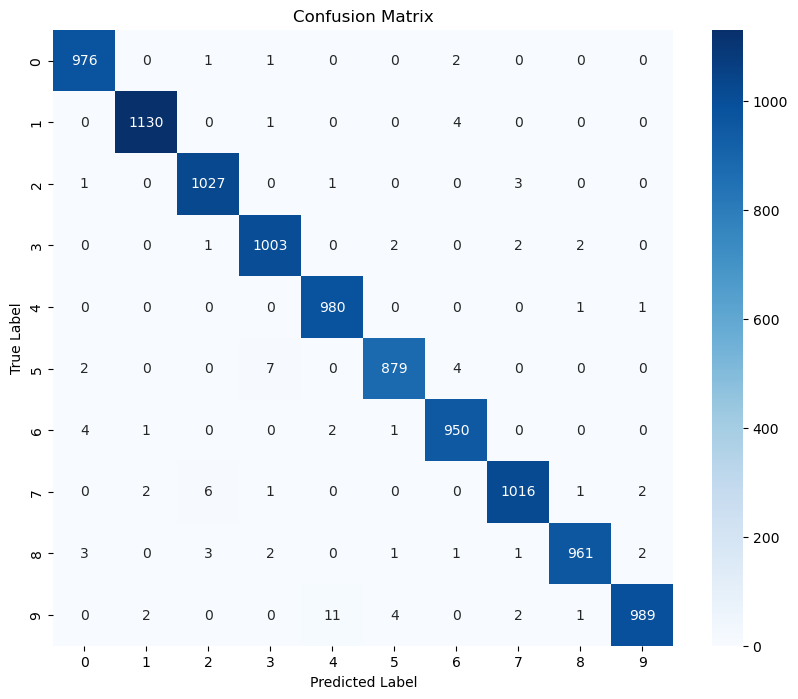

In [13]:
# Define the convolutional neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(self.dropout1(x), 2)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(self.dropout2(x)))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# Set the device to run on GPU if available otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the data preprocessing steps
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Display the first five images and their labels
denormalize = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))
print("\nDisplaying the first 5 training images and labels:")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    image, label = train_dataset[i]
    image_denorm = denormalize(image)
    axes[i].imshow(image_denorm.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model and optimizer
model = Net().to(device)
optimizer = optim.Adam(model.parameters())

# Compile the model using torch 2.0's optimizer
model = torch.compile(model)

# Setup and run the training loop
def train(model, device, train_loader, optimizer, epochs):
    model.train()
    print("\nStarting training...")
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.functional.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch}/{epochs} complete. Loss: {loss.item():.4f}')

# Train on 3 epochs
train(model, device, train_loader, optimizer, epochs=3)


# Define and run the testing loop to report accuracy and gather data for confusion matrix
def test_and_evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Get predictions and true labels for confusion matrix
            all_preds.extend(pred.squeeze().tolist())
            all_targets.extend(target.tolist())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # Display the test accuracy
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    
    return all_targets, all_preds

# Run the evaluation function
true_labels, predicted_labels = test_and_evaluate(model, device, test_loader)

# Display a confusion matrix
print("\nDisplaying Confusion Matrix...")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Summarize your results

The results showed that the test results were excellent. The average test loss was extreamly low at .0296. The test accuracy showed a high accuracy of 99.11%. The model correctly classified 9,911 out of 10,000 images.